In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
# import cv2
# import numpy as np
import random
from scipy.stats import norm
from scipy.signal import convolve2d

In [2]:
def resize_img(im,grayscale,desired_size = 512 ):
#   im = Image.open(im_pth)
#   old_size = im.size  # old_size[0] is in (width, height) format
#   im = cv2.imread(im_pth)
  old_size = im.shape[0:2]
  if grayscale:
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
  old_size = im.shape[:2] # old_size is in (height, width) format
  ratio = float(desired_size)/max(old_size)
  new_size = tuple([int(x*ratio) for x in old_size])

  # new_size should be in (width, height) format
  im = cv2.resize(im, (new_size[1], new_size[0])) 

  delta_w = desired_size - new_size[1]
  delta_h = desired_size - new_size[0]
  top, bottom = delta_h//2, delta_h-(delta_h//2)
  left, right = delta_w//2, delta_w-(delta_w//2)

  color = [0, 0, 0]
  new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
      value=color)
  new_im = cv2.cvtColor(new_im,cv2.COLOR_BGR2RGB)
  return new_im

def gamma_correction(gamma,img_original):
    lookUpTable = np.empty((1,256), np.uint8)
    for i in np.arange(0,256):
        print(i)
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    res = cv2.LUT(img_original, lookUpTable)
    return res

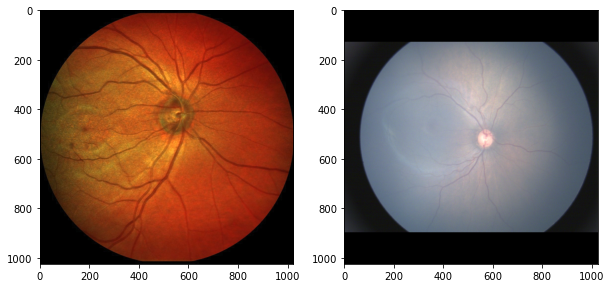

In [3]:
main_dir = r'G:\My Drive\CMKL\datasets\quality\train'
path1 = os.path.join(main_dir,'good')
path2 = os.path.join(main_dir,'bad')

imgs1 = os.listdir(path1)
imgs2 = os.listdir(path2)

pix = -2

im1 = cv2.imread(os.path.join(path1,imgs1[pix]))
im2 = cv2.imread(os.path.join(path2,imgs2[pix]))
im1_rsz =resize_img(im1,False,1024)
im2_rsz =resize_img(im2,False,1024)

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax[0].imshow(im1_rsz)
ax[1].imshow(im2_rsz)


In [4]:
def preprocessing_bengraham(img,alpha,beta,gamma):
#     img = cv2.cvtColor(img,cv2.cv2.COLOR_BGR2RGB)
    img2 = cv2.GaussianBlur(img,(0,0),img.shape[0]/10)
    img = cv2.addWeighted(img,alpha,img2,beta,gamma)
    return img

In [5]:
def normalize_image(img_out):
    img_out2 = img_out.copy()
    img_out2 = (img_out2-img_out2.min())/(img_out2.max()-img_out2.min())
    return img_out2

In [6]:
def create_ltd(im0):
    def convert_to_uint8(im0):
        im1 = im0.copy()
        im1x = im1/im1.max()
        im1x = 255*im1x
        im1x = im1x.astype(np.uint8)
        return im1x
    img=im0.copy()
    if (img.min() != 0) and (img.max() != 1):
        img = normalize_image(img)
    w = img.shape[0]
    r_L = random.randint(0.75*w,w)
    if r_L%2 == 0:
        r_L+=1
    a,b = random.randint(np.round(0.375*r_L),np.round(0.625*r_L)),random.randint(np.round(0.375*r_L),np.round(0.625*r_L))
    sigma = []
    for i in [a,b]:
        if i<w-i:
            sigma.append(random.randint(np.round(0.66*i*r_L),np.round(0.66*(w-i)*r_L)))
        else:
            sigma.append(random.randint(np.round(0.66*(w-i)*r_L),np.round(0.66*i*r_L)))
    print(r_L,sigma)
    mask = cv2.GaussianBlur(img, (r_L,r_L),sigmaX=sigma[0],sigmaY=sigma[1])
    
    kernels = [[0.63,0.80,0.35],[0.56,0.93,0.93],[1,1,1]]
    ix_kernel = random.randint(0,2)
    print(ix_kernel)
    kernel = np.array(kernels[ix_kernel]) # np.array([0.63,0.80,0.35])
    kernel = np.reshape(kernel,(1,kernel.size))
    
    alpha,beta = 2,50
    im_embossed = np.zeros(mask.shape)
    maskx = mask.copy()/255
    imgx = img.copy()/255
#     maskx = mask.copy()
#     imgx = img.copy()
    for i in range(3):
        im_embossed[:,:,i] = convolve2d(maskx[:,:,i],kernel,mode = 'same',boundary='symm')
    img1x = imgx+im_embossed
#     im1x = im1/im1.max()
#     im1x = 255*im1x
    im1x = convert_to_uint8(im1)
    img1 = im1x.copy()
    print(img1.max(),img1.min())
    img_out = np.zeros(im_embossed.shape)
    for i in range(im_embossed.shape[0]):
        for j in range(im_embossed.shape[1]):
            for k in range(im_embossed.shape[2]):
                img_out[i,j,k] = np.clip(alpha*img1[i,j,k]+beta,0,255)
#     img_out = imgx+im_embossed
    img_out = normalize_image(img_out)
    img1x = convert_to_uint8(img1x)
    img_out = convert_to_uint8(img_out)
    return img1x,img_out

In [7]:
img = im1_rsz.copy()
im1,im2 = create_ltd(img)

1001 [309965, 372954]
0
255 0


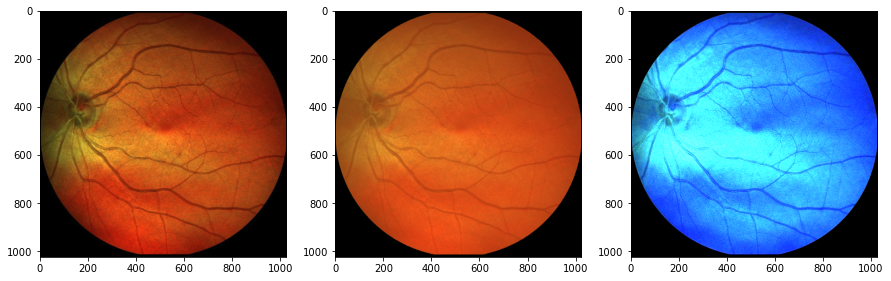

In [8]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
ix = np.where(img[:,:,0]<27)
im1[ix]=0
im2[ix]=0
ax[0].imshow(img)
ax[1].imshow(im1)
ax[2].imshow(im2)

In [9]:
def get_cdf_hist(image_input):
    """
    Method to compute histogram and cumulative distribution function
    :param image_input: input image
    :return: cdf
    """
    hist, bins = np.histogram(image_input.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()
    return cdf_normalized

In [10]:
import cv2
import numpy as np
import random
from scipy.stats import norm

In [11]:
def _decayed_value_in_norm(x, max_value, min_value, center, range):
    """
    decay from max value to min value following Gaussian/Normal distribution
    """
    radius = range / 3
    center_prob = norm.pdf(center, center, radius)
    x_prob = norm.pdf(x, center, radius)
    x_value = (x_prob / center_prob) * (max_value - min_value) + min_value
    return x_value
def _decayed_value_in_linear(x, max_value, padding_center, decay_rate):
    """
    decay from max value to min value with static linear decay rate.
    """
    x_value = max_value - abs(padding_center - x) * decay_rate
    if x_value < 0:
        x_value = 1
    return x_value

def generate_parallel_light_mask(mask_size,
                                 position=None,
                                 direction=None,
                                 max_brightness=255,
                                 min_brightness=0,
                                 mode="gaussian",
                                 linear_decay_rate=None):
    """
    Generate decayed light mask generated by light strip given its position, direction
    Args:
        mask_size: tuple of integers (w, h) defining generated mask size
        position: tuple of integers (x, y) defining the center of light strip position,
                  which is the reference point during rotating
        direction: integer from 0 to 360 to indicate the rotation degree of light strip
        max_brightness: integer that max brightness in the mask
        min_brightness: integer that min brightness in the mask
        mode: the way that brightness decay from max to min: linear or gaussian
        linear_decay_rate: only valid in linear_static mode. Suggested value is within [0.2, 2]
    Return:
        light_mask: ndarray in float type consisting value from 0 to strength
    """
    if position is None:
        pos_x = random.randint(0, mask_size[0])
        pos_y = random.randint(0, mask_size[1])
    else:
        pos_x = position[0]
        pos_y = position[1]
    if direction is None:
        direction = random.randint(0, 360)
        print("Rotate degree: ", direction)
    if linear_decay_rate is None:
        if mode == "linear_static":
            linear_decay_rate = random.uniform(0.2, 2)
        if mode == "linear_dynamic":
            linear_decay_rate = (max_brightness - min_brightness) / max(mask_size)
    assert mode in ["linear_dynamic", "linear_static", "gaussian"], \
        "mode must be linear_dynamic, linear_static or gaussian"
    padding = int(max(mask_size) * np.sqrt(2))
    # add padding to satisfy cropping after rotating
    canvas_x = padding * 2 + mask_size[0]
    canvas_y = padding * 2 + mask_size[1]
    mask = np.zeros(shape=(canvas_y, canvas_x), dtype=np.float32)
    # initial mask's up left corner and bottom right corner coordinate
    init_mask_ul = (int(padding), int(padding))
    init_mask_br = (int(padding+mask_size[0]), int(padding+mask_size[1]))
    init_light_pos = (padding + pos_x, padding + pos_y)
    # fill in mask row by row with value decayed from center
    for i in range(canvas_y):
        if mode == "linear":
            i_value = _decayed_value_in_linear(i, max_brightness, init_light_pos[1], linear_decay_rate)
        elif mode == "gaussian":
            i_value = _decayed_value_in_norm(i, max_brightness, min_brightness, init_light_pos[1], mask_size[1])
        else:
            i_value = 0
        mask[i] = i_value
    # rotate mask
    rotate_M = cv2.getRotationMatrix2D(init_light_pos, direction, 1)
    mask = cv2.warpAffine(mask, rotate_M, (canvas_x,  canvas_y))
    # crop
    mask = mask[init_mask_ul[1]:init_mask_br[1], init_mask_ul[0]:init_mask_br[0]]
    mask = np.asarray(mask, dtype=np.uint8)
    # add median blur
    mask = cv2.medianBlur(mask, 9)
    mask = 255 - mask
    # cv2.circle(mask, init_light_pos, 1, (0, 0, 255))
    # cv2.imshow("crop", mask[init_mask_ul[1]:init_mask_br[1], init_mask_ul[0]:init_mask_br[0]])
    # cv2.imshow("all", mask)
    # cv2.waitKey(0)
    return mask

def add_parallel_light(image, light_position=None, direction=None, max_brightness=255, min_brightness=0,
                       mode="gaussian", linear_decay_rate=None, transparency=None):
    """
    Add mask generated from parallel light to given image
    """
    if transparency is None:
        transparency = random.uniform(0.5, 0.85)
    frame = cv2.imread(image)
    height, width, _ = frame.shape
    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = generate_parallel_light_mask(mask_size=(width, height),
                                        position=light_position,
                                        direction=direction,
                                        max_brightness=max_brightness,
                                        min_brightness=min_brightness,
                                        mode=mode,
                                        linear_decay_rate=linear_decay_rate)
    hsv[:, :, 2] = hsv[:, :, 2] * transparency + mask * (1 - transparency)
    frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    frame[frame > 255] = 255
    frame = np.asarray(frame, dtype=np.uint8)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return rgb_img,frame,mask

In [12]:
def generate_spot_light_mask(mask_size,
                             position=None,
                             max_brightness=255,
                             min_brightness=0,
                             mode="gaussian",
                             linear_decay_rate=None,
                             speedup=False):
    """
    Generate decayed light mask generated by spot light given position, direction. Multiple spotlights are accepted.
    Args:
        mask_size: tuple of integers (w, h) defining generated mask size
        position: list of tuple of integers (x, y) defining the center of spotlight light position,
                  which is the reference point during rotating
        max_brightness: integer that max brightness in the mask
        min_brightness: integer that min brightness in the mask
        mode: the way that brightness decay from max to min: linear or gaussian
        linear_decay_rate: only valid in linear_static mode. Suggested value is within [0.2, 2]
        speedup: use `shrinkage then expansion` strategy to speed up vale calculation
    Return:
        light_mask: ndarray in float type consisting value from max_brightness to min_brightness. If in 'linear' mode
                    minimum value could be smaller than given min_brightness.
    """
    if position is None:
        position = [(random.randint(0, mask_size[0]), random.randint(0, mask_size[1]))]
    if linear_decay_rate is None:
        if mode == "linear_static":
            linear_decay_rate = random.uniform(0.25, 1)
    assert mode in ["linear", "gaussian"], \
        "mode must be linear_dynamic, linear_static or gaussian"
    mask = np.zeros(shape=(mask_size[1], mask_size[0]), dtype=np.float32)
    if mode == "gaussian":
        mu = np.sqrt(mask.shape[0]**2+mask.shape[1]**2)
        dev = mu / 3.5
        mask = _decay_value_radically_norm_in_matrix(mask_size, position, max_brightness, min_brightness, dev)
    mask = np.asarray(mask, dtype=np.uint8)
    # add median blur
    mask = cv2.medianBlur(mask, 5)
    mask = 255 - mask
    # cv2.imshow("mask", mask)
    # cv2.waitKey(0)
    return mask

def _decay_value_radically_norm_in_matrix(mask_size, centers, max_value, min_value, dev):
    """
    _decay_value_radically_norm function in matrix format
    """
    center_prob = norm.pdf(0, 0, dev)
    x_value_rate = np.zeros((mask_size[1], mask_size[0]))
    for center in centers:
        coord_x = np.arange(mask_size[0])
        coord_y = np.arange(mask_size[1])
        xv, yv = np.meshgrid(coord_x, coord_y)
        dist_x = xv - center[0]
        dist_y = yv - center[1]
        dist = np.sqrt(np.power(dist_x, 2) + np.power(dist_y, 2))
        x_value_rate += norm.pdf(dist, 0, dev) / center_prob
    mask = x_value_rate * (max_value - min_value) + min_value
    mask[mask > 255] = 255
    return mask

def _decay_value_radically_norm(x, centers, max_value, min_value, dev):
    """
    Calculate point value decayed from center following Gaussian decay. If multiple centers are given, value
    from each center sums up while limiting the accumulated value into [0, 255]
    NOTE: assuming light at each center is identical: same brightness and same decay rate
    """
    center_prob = norm.pdf(0, 0, dev)
    x_value_rate = 0
    for center in centers:
        distance = np.sqrt((center[0]-x[0])**2 + (center[1]-x[1])**2)
        x_value_rate += norm.pdf(distance, 0, dev) / center_prob
    x_value = x_value_rate * (max_value - min_value) + min_value
    x_value = 255 if x_value > 255 else x_value
    return x_value

def add_spot_light(image, light_position=None, max_brightness=255, min_brightness=0,
                   mode='gaussian', linear_decay_rate=None, transparency=None):
    """
    Add mask generated from spot light to given image
    """
    if transparency is None:
        transparency = random.uniform(0.5, 0.85)
    frame = cv2.imread(image)
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    height, width, _ = frame.shape
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = generate_spot_light_mask(mask_size=(width, height),
                                    position=light_position,
                                    max_brightness=max_brightness,
                                    min_brightness=min_brightness,
                                    mode=mode,
                                    linear_decay_rate=linear_decay_rate)
    hsv[:, :, 2] = hsv[:, :, 2] * transparency + mask * (1 - transparency)
    frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    frame[frame > 255] = 255
    frame = np.asarray(frame, dtype=np.uint8)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return image,frame,mask

In [13]:
image,frame,mask = add_parallel_light(img_path,mode='gaussian')
ix = np.where(image<27)
frame[ix]=0
cdf1 = get_cdf_hist(image)
cdf2 = get_cdf_hist(frame)
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
ax[0][0].imshow(image)
ax[1][0].imshow(frame)
ax[0][1].hist(image.flatten(), 256, [0, 256], color='r')
ax1=ax[0][1].twinx()
ax1.plot(cdf1)
ax[1][1].hist(frame.flatten(), 256, [0, 256], color='r')
ax2=ax[1][1].twinx()
ax2.plot(cdf2)
ax2.set_xlim([1,256])
plt.figure()
plt.imshow(mask,cmap='gray')

NameError: name 'img_path' is not defined

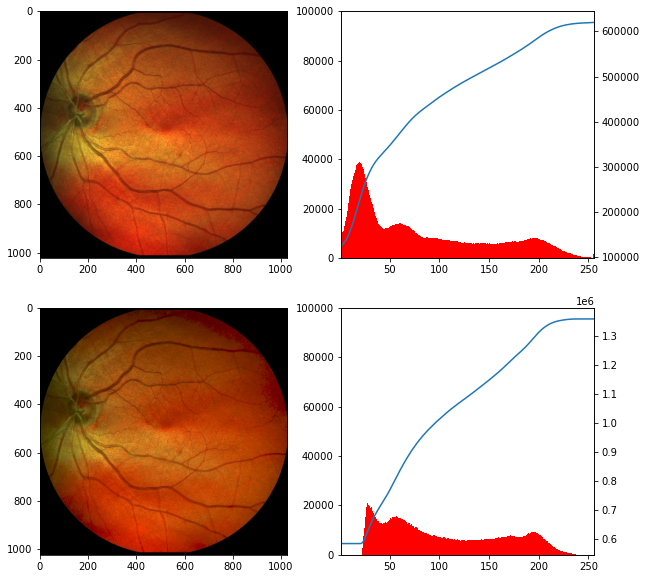

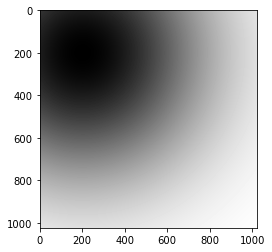

In [133]:
image,frame,mask = add_spot_light(img_path,mode='gaussian',light_position=[(200,200)])
ix = np.where(image<27)
frame[ix]=0
cdf1 = get_cdf_hist(image)
cdf2 = get_cdf_hist(frame)
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
ax[0][0].imshow(image)
ax[1][0].imshow(frame)
ax[0][1].hist(image.flatten(), 256, [0, 256], color='r')
ax1=ax[0][1].twinx()
ax1.plot(cdf1)
ax[0][1].set_ylim([0,1e5])
ax1.set_xlim([1,256])
ax[1][1].hist(frame.flatten(), 256, [0, 256], color='r')
ax2=ax[1][1].twinx()
ax2.plot(cdf2)
ax[1][1].set_ylim([0,1e5])
ax2.set_xlim([1,256])
plt.figure()
plt.imshow(mask,cmap='gray')
# ax2.set_xticks(np.arange(1,256,1))

In [129]:
random.randint(0, 1024)

433

In [31]:
mean = 0
var = 0.1
sigma = var**0.5
gauss = np.random.normal(mean,sigma,(img.shape))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


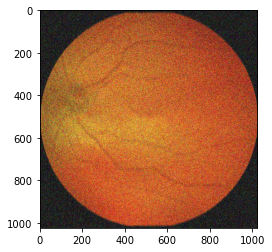

In [32]:
plt.imshow(im_embossed+gauss)

In [22]:
cdf = get_cdf_hist(img)

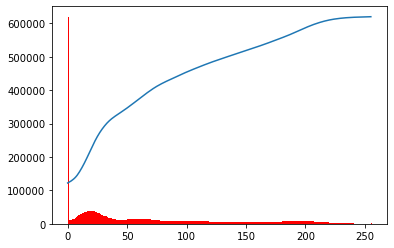

In [23]:
plt.hist(img.flatten(), 256, [0, 256], color='r')
plt.plot(cdf)

In [135]:
# https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
def auto_canny(image, sigma=0.33):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
	# return the edged image
	return edged

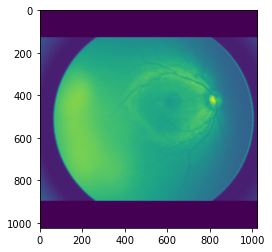

In [148]:
im2_hsv = cv2.cvtColor(im2_rsz,cv2.COLOR_BGR2HSV)
im2_gray = cv2.cvtColor(im2_rsz,cv2.COLOR_BGR2GRAY)
h,s,v = cv2.split(im2_hsv)
blurred = cv2.GaussianBlur(im2_gray,(5,5), 0)
# blurred = cv2.medianBlur(im2_gray,15)
plt.imshow(blurred)

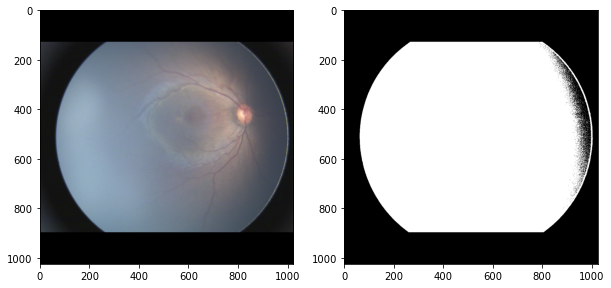

In [161]:
ret, thresh = cv2.threshold(im2_gray, 0, 255, 
                            cv2.THRESH_BINARY
                            +cv2.THRESH_OTSU)
#                            )
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(im2_rsz)
ax[1].imshow(thresh,cmap='gray')

In [145]:
# np.unique(ret2)

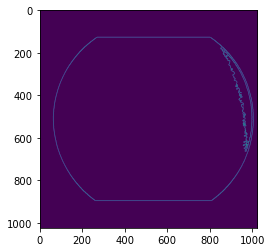

In [171]:
plt.imshow()

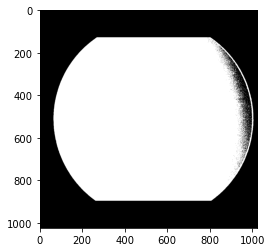

In [182]:
im_floodfill = thresh.copy()
# h, w = thresh.shape[:2]
# mask = np.zeros((h+2, w+2), np.uint8)
# cv2.floodFill(im_floodfill, mask, (0,0), 255)
plt.imshow(im_floodfill,cmap='gray')

In [245]:
def kmeans_color_quantization(image, clusters=8, rounds=1):
    h, w = image.shape[:2]
    samples = np.zeros([h*w], dtype=np.float32)
    count = 0

    for x in range(h):
        for y in range(w):
            samples[count] = image[x][y]
            count += 1

    compactness, labels, centers = cv2.kmeans(samples,
            clusters, 
            None,
            (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 0.001), 
            rounds, 
            cv2.KMEANS_RANDOM_CENTERS)
    
    centers = np.uint8(centers)
    print(np.unique(centers),centers.shape)
    a,b = np.unique(centers)[0],np.unique(centers)[1]
    if a<b:
        centers[centers==a]=0
        centers[centers==b]=255
    else:
        centers[centers==a]=255
        centers[centers==b]=0
        
    res = centers[labels.flatten()]
    return res.reshape((image.shape))

def detect_foregroud(im1):
    kmeans = kmeans_color_quantization(im1, clusters=2)
    result = kmeans.copy()
    h, w = result.shape[:2]
    im_floodfill = result.copy()
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 255);
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    im_out = result | im_floodfill_inv
#     _,ax = plt.subplots(1,2)
#     ax[0].imshow(im_out,cmap='gray')
#     kernel = np.ones((10,10),np.uint8)
#     im_out = cv2.dilate(im_out,kernel,iterations = 5)
#     ax[1].imshow(im_out,cmap='gray')
    return im_out

def preprocessing_bengraham(img,alpha,beta,gamma):
#     img = cv2.cvtColor(img,cv2.cv2.COLOR_BGR2RGB)
    img2 = cv2.GaussianBlur(img,(0,0),27)
    img = cv2.addWeighted(img,alpha,img2,beta,gamma)
    return img

def clahe_rgb(img,clipLimit=2,gridsize=5):
# #     bgr = cv.imread(input_path)
#     lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
#     lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clipLimit,tileGridSize=(gridsize,gridsize))
    img2 = clahe.apply(img)
#     lab = cv2.merge(lab_planes)
#     bgr2 = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
#     cdf = get_cdf_hist(bgr2)
    return img2

def clahe_rgb2(bgr,clipLimit=2,gridsize=5):
#     bgr = cv.imread(input_path)
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clipLimit,tileGridSize=(gridsize,gridsize))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    bgr2 = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
#     cdf = get_cdf_hist(bgr2)
    return bgr2

[ 3 75] (2, 1)


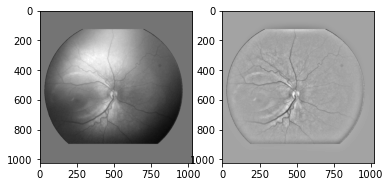

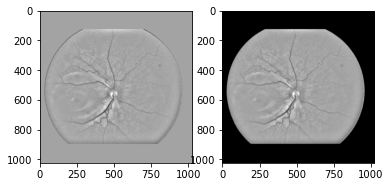

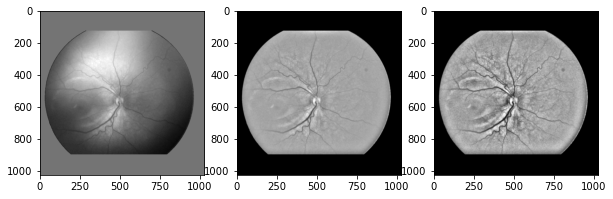

In [440]:
# for pix in range(0,len(imgs2)-1):
pix = 0
gridsize=20#5
alpha=30#30
beta = -alpha
gamma=200#200ฟ
kernel = np.ones((5,5),np.uint8)

im2 = cv2.imread(os.path.join(path2,imgs2[pix]))
im2_rsz =resize_img(im2,False,1024)
b,g,r = cv2.split(im2_rsz)
im2_gray = 0.2989*r+0.5870*g+0.1140*b
# plt.imshow(im2_gray)
# im2_gray = g.copy()
im2_gray = cv2.morphologyEx(im2_gray,cv2.MORPH_OPEN,kernel)
im_out = detect_foregroud(im2_gray)
im_fore = im2_gray.copy()
im_fore[im_out==0]=im_fore[im_out==255].mean()
_,ax = plt.subplots(1,2)
ax[0].imshow(im_fore,cmap='gray')
im_pre = preprocessing_bengraham(im_fore,alpha,beta,gamma)
im_pre[im_out==0]=0
im_pre = preprocessing_bengraham(im_pre,alpha,beta,gamma)
ax[1].imshow(im_pre,cmap='gray')
im_pre[im_out==0]=0
_,ax = plt.subplots(1,2)
ax[0].imshow(im_pre,cmap='gray')
im_pre = cv2.normalize(im_pre, None, alpha=0, beta=255,\
                       norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)
im_pre[im_out==0]=0
ax[1].imshow(im_pre,cmap='gray')
im_clahe = clahe_rgb(im_pre,gridsize)

im_clahe[im_out==0]=0
_,ax = plt.subplots(1,3,figsize=(10,5))
# ax[0].imshow(im_out,cmap='gray')
ax[0].imshow(im_fore,cmap='gray')
ax[1].imshow(im_pre,cmap='gray')
ax[2].imshow(im_clahe,cmap='gray')

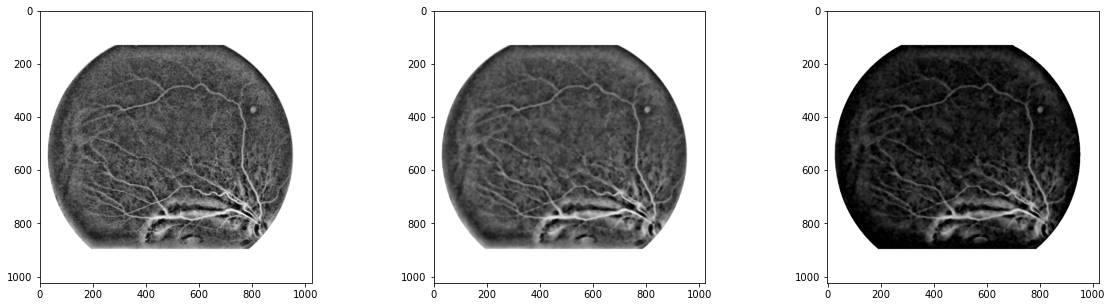

In [434]:
im_pre[im_out==0]=0
im_clahe2 = 255-im_clahe
im_clahe2 = clahe_rgb(im_clahe2,gridsize)
im_med = cv2.medianBlur(im_clahe2, 9)
kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (101, 101))
im_top = cv2.morphologyEx(im_med, cv2.MORPH_TOPHAT, kernel2)
im_top[im_out==0]=255
im_thresh2 = cv2.adaptiveThreshold(im_top, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 13, 1)
_,ax = plt.subplots(1,3,figsize=(20,5))
ax[0].imshow(im_clahe2,cmap='gray')
ax[1].imshow(im_med,cmap='gray')
ax[2].imshow(im_top,cmap='gray')
# ax[3].imshow(im_thresh2,cmap='gray')

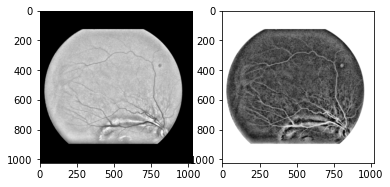

In [421]:
_,ax = plt.subplots(1,2)
ax[0].imshow(im_clahe,cmap='gray')
ax[1].imshow(im_clahe2,cmap='gray')

[  2 113] (2, 1)
[22 95] (2, 1)
[  5 176] (2, 1)


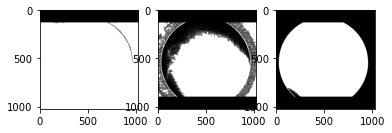

In [359]:
im2_hsv = cv2.cvtColor(im2_rsz,cv2.COLOR_BGR2HSV)
b,g,r = cv2.split(im2_hsv)
_,ax = plt.subplots(1,3)
ix=0
for i in [b,g,r]:
    i = detect_foregroud(i)
    ax[ix].imshow(i,cmap='gray')
    ix+=1

[  5 176] (2, 1)


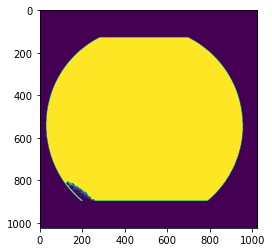

In [358]:
r_out = detect_foregroud(r)
plt.imshow(r_out)

# Test automatic CLAHE

In [2]:
# 18Feb2021
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

#INTERPOLATION FUNCTION
def interpolate(subBin,LU,RU,LB,RB,subX,subY):
    subImage = np.zeros(subBin.shape)
    num = subX*subY
    for i in range(subX):
        inverseI = subX-i
        for j in range(subY):
            inverseJ = subY-j
            val = subBin[i,j].astype(int)
            subImage[i,j] = np.floor((inverseI*(inverseJ*LU[val] + j*RU[val])+ i*(inverseJ*LB[val] + j*RB[val]))/float(num))
    return subImage

#CLAHE FUNCTION
#ALL UTILITY FUNCTIONS COMBINED INTO ONE FUNCTION
def clahe(img,clipLimit,nrBins=128,nrX=0,nrY=0):
    '''img - Input image
       clipLimit - Normalized clipLimit. Higher value gives more contrast
       nrBins - Number of graylevel bins for histogram("dynamic range")
       nrX - Number of contextial regions in X direction
       nrY - Number of Contextial regions in Y direction'''
    h,w = img.shape
    if clipLimit==1:
        return
    nrBins = max(nrBins,128)
    if nrX==0:
        #Taking dimensions of each contextial region to be a square of 32X32
        xsz = 32
        ysz = 32
        nrX = np.ceil(h/xsz).astype(int)#240
        #Excess number of pixels to get an integer value of nrX and nrY
        excX= int(xsz*(nrX-h/xsz))
        nrY = np.ceil(w/ysz).astype(int)#320
        excY= int(ysz*(nrY-w/ysz))
        #Pad that number of pixels to the image
        if excX!=0:
            img = np.append(img,np.zeros((excX,img.shape[1])).astype(int),axis=0)
        if excY!=0:
            img = np.append(img,np.zeros((img.shape[0],excY)).astype(int),axis=1)
    else:
        xsz = round(h/nrX)
        ysz = round(w/nrY)
    
    nrPixels = xsz*ysz
    xsz2 = round(xsz/2)
    ysz2 = round(ysz/2)
    claheimg = np.zeros(img.shape)
    
    if clipLimit > 0:
        clipLimit = max(1,clipLimit*xsz*ysz/nrBins)
    else:
        clipLimit = 50
    
    #makeLUT
    print("...Make the LUT...")
    minVal = 0 #np.min(img)
    maxVal = 255 #np.max(img)
    
    #maxVal1 = maxVal + np.maximum(np.array([0]),minVal) - minVal
    #minVal1 = np.maximum(np.array([0]),minVal)
    
    binSz = np.floor(1+(maxVal-minVal)/float(nrBins))
    LUT = np.floor((np.arange(minVal,maxVal+1)-minVal)/float(binSz))
    
    #BACK TO CLAHE
    bins = LUT[img]
    print(bins.shape)
    #makeHistogram
    print("...Making the Histogram...")
    hist = np.zeros((nrX,nrY,nrBins))
    print(nrX,nrY,hist.shape)
    for i in range(nrX):
        for j in range(nrY):
            bin_ = bins[i*xsz:(i+1)*xsz,j*ysz:(j+1)*ysz].astype(int)
            for i1 in range(xsz):
                for j1 in range(ysz):
                    hist[i,j,bin_[i1,j1]]+=1
    
    #clipHistogram
    print("...Clipping the Histogram...")
    if clipLimit>0:
        for i in range(nrX):
            for j in range(nrY):
                nrExcess = 0
                for nr in range(nrBins):
                    excess = hist[i,j,nr] - clipLimit
                    if excess>0:
                        nrExcess += excess
                
                binIncr = nrExcess/nrBins
                upper = clipLimit - binIncr
                for nr in range(nrBins):
                    if hist[i,j,nr] > clipLimit:
                        hist[i,j,nr] = clipLimit
                    else:
                        if hist[i,j,nr]>upper:
                            nrExcess += upper - hist[i,j,nr]
                            hist[i,j,nr] = clipLimit
                        else:
                            nrExcess -= binIncr
                            hist[i,j,nr] += binIncr
                
                if nrExcess > 0:
                    stepSz = max(1,np.floor(1+nrExcess/nrBins))
                    for nr in range(nrBins):
                        nrExcess -= stepSz
                        hist[i,j,nr] += stepSz
                        if nrExcess < 1:
                            break
    
    #mapHistogram
    print("...Mapping the Histogram...")
    map_ = np.zeros((nrX,nrY,nrBins))
    #print(map_.shape)
    scale = (maxVal - minVal)/float(nrPixels)
    for i in range(nrX):
        for j in range(nrY):
            sum_ = 0
            for nr in range(nrBins):
                sum_ += hist[i,j,nr]
                map_[i,j,nr] = np.floor(min(minVal+sum_*scale,maxVal))
    
    #BACK TO CLAHE
    #INTERPOLATION
    print("...interpolation...")
    xI = 0
    for i in range(nrX+1):
        if i==0:
            subX = int(xsz/2)
            xU = 0
            xB = 0
        elif i==nrX:
            subX = int(xsz/2)
            xU = nrX-1
            xB = nrX-1
        else:
            subX = xsz
            xU = i-1
            xB = i
        
        yI = 0
        for j in range(nrY+1):
            if j==0:
                subY = int(ysz/2)
                yL = 0
                yR = 0
            elif j==nrY:
                subY = int(ysz/2)
                yL = nrY-1
                yR = nrY-1
            else:
                subY = ysz
                yL = j-1
                yR = j
            UL = map_[xU,yL,:]
            UR = map_[xU,yR,:]
            BL = map_[xB,yL,:]
            BR = map_[xB,yR,:]
            #print("CLAHE vals...")
            subBin = bins[xI:xI+subX,yI:yI+subY]
            #print("clahe subBin shape: ",subBin.shape)
            subImage = interpolate(subBin,UL,UR,BL,BR,subX,subY)
            claheimg[xI:xI+subX,yI:yI+subY] = subImage
            yI += subY
        xI += subX
    
    if excX==0 and excY!=0:
        return claheimg[:,:-excY]
    elif excX!=0 and excY==0:
        return claheimg[:-excX,:]
    elif excX!=0 and excY!=0:
        return claheimg[:-excX,:-excY]
    else:
        return claheimg

In [ ]:
image = io.imread('example.jpg')
clahe_img = clahe(image[:,:,0],8,0,0)
#clipLimit = 8 gave decent results on eyePACs Dataset
#and setting xsz and ysz = 32
#and calculating nrX and nrY

fig,axs = plt.subplots(1,2,figsize=(200,100))
axs[0].imshow(image[:,:,0],cmap='gray')
axs[1].imshow(clahe_img,cmap='gray')
plt.show()

# ACLAHEDGC

In [3]:
import os
import cv2
# import 

In [5]:
main_dir = r'G:\My Drive\CMKL\datasets\quality\train'
path1 = os.path.join(main_dir,'good')
path2 = os.path.join(main_dir,'bad')

imgs1 = os.listdir(path1)
imgs2 = os.listdir(path2)

pix = -2

im1 = cv2.imread(os.path.join(path1,imgs1[pix]))
im2 = cv2.imread(os.path.join(path2,imgs2[pix]))

In [194]:
# np.max([1,5])

In [196]:
globalHistogram = np.zeros((hsbBrightnessMaxIntValue+1,))
x = cutImage[0,0]
for i in x:
    globalHistogram[i]+=1

In [241]:
def automatic_clahe(hsv,blocksize = 2,alpha = 100,P=15,D = 50):
    def cal_histogram(histo,img):
        for i in img:
            histo[i]+=1
        return histo
        
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    numblockCol = blocksize
    numblockRow = blocksize
    pixelperblockCol = int(hsv.shape[0]/numblockCol)
    pixelperblockRow = int(hsv.shape[1]/numblockRow)
    pixelperBlock = pixelperblockCol*pixelperblockRow
#     print(numblockCol,numblockRow,pixelperblockCol,pixelperblockRow)
    cutImage= np.zeros((numblockCol,numblockRow,pixelperblockCol,pixelperblockRow,1),dtype=np.uint8)
    h,s,hsbBrightnessValues = cv2.split(hsv)
    # // -- STEP 1 : Image Decomposition -- //
#     for c in range(0,hsv.shape[0]):
#         for  r in range(0,hsv.shape[1]):
#             blockCol = int(c/pixelperblockCol)
#             blockRow = int(r/pixelperblockRow)
#             pixelCol = c%pixelperblockCol
#             pixelRow = r%pixelperblockRow
#             print(blockCol,blockRow)
#             print(pixelCol,pixelRow)
#             cutImage[blockCol,blockRow,pixelCol,pixelRow] = hsbBrightnessValues[c,r]

    for blockCol in range(0,numblockCol):
        col_start = blockCol*pixelperblockCol
        col_stop = col_start+pixelperblockCol
        for blockRow in range(0,numblockRow):
            row_start = blockRow*pixelperblockRow
            row_stop = row_start+pixelperblockRow
            cutImage[blockCol,blockRow,:,:,0] = hsbBrightnessValues[col_start:col_stop,row_start:row_stop]
            
    # // -- STEP 2 : Histogram Calculations -- //
    hsbBrightnessMaxIntValue = 255
    histogramsPerBlock = np.zeros((numblockCol,numblockRow,hsbBrightnessMaxIntValue+1),dtype=np.uint64)
    minPerBlock = np.zeros((numblockCol,numblockRow),dtype=np.uint8)
    maxPerBlock = np.zeros((numblockCol,numblockRow),dtype=np.uint8)
    avgPerBlock = np.zeros((numblockCol,numblockRow),dtype=np.uint64)
    stdPerBlock = np.zeros((numblockCol,numblockRow),dtype = np.float64)
    Lmax = -1000
    globalHistogram = np.zeros((hsbBrightnessMaxIntValue+1,))

    for  blockC in range(0,numblockCol):
        for blockR in range(0,numblockRow):
            blockImg = cutImage[blockC,blockR]
            minPerBlock[blockC,blockR] = np.min(blockImg)
            maxPerBlock[blockC,blockR] = np.max(blockImg)
            avgPerBlock[blockC,blockR] = np.mean(blockImg)
            stdPerBlock[blockC,blockR] = np.std(blockImg)
            Lmax = np.max([Lmax,maxPerBlock[blockC,blockR]])
            globalHistogram = cal_histogram(globalHistogram,blockImg)
            histogramsPerBlock[blockC,blockR] = cal_histogram(histogramsPerBlock[blockC,blockR],blockImg)

    cdfTarget = int(pixelperBlock*numblockCol*numblockRow*0.75)
    LalphaDiff = sys.maxsize
    Lalpha = 0
    for i in range(0,len(globalHistogram)):
        if i>0:
            globalHistogram[i] += globalHistogram[i-1]
        diff = np.abs(globalHistogram[i]-cdfTarget)
        if diff < LalphaDiff:
            LalphaDiff = diff
            Lalpha = i
            
    # standard deviation for each block 2nd
#     stdPerBlock = np.zeros((numblockCol,numblockRow),dtype = float)
#     # // calculate the standard deviation for each block
#     for  blockC in range(0,numblockCol):
#         for blockR in range(0,numblockRow):
#             stdPerBlock[blockC,blockR] = np.std(cutImage[blockC,blockR])
            
    # // -- STEP 3 : Histogram Clipping Redistribution -- //
    '''Clips the histogram for each block w/ the following clipping threshold β, where:
    β = (M/N)*(1+P*(lmax/R)+(α/100)*(σ/(Avg+c)))
    M = # pixels in each block
    N = dynamic range of the block
    lmax = max pixel value in each block
    R = hsbBrightnessMaxIntValue
    c = 0.0001
    Avg = average pixel value
    P, α = passed parameters
    '''
    M = pixelperblockCol*pixelperblockRow

    # redistribute the histogram
    for  blockC in range(0,numblockCol):
        for blockR in range(0,numblockRow):
            # calculate the clipping point
            lmax = maxPerBlock[blockC,blockR]
            N = lmax-minPerBlock[blockC,blockR]
            avg = avgPerBlock[blockC,blockR]
            std = stdPerBlock[blockC,blockR]
#             print(M,std,avg,lmax,N)
            B = int((M/N)*(1.0+P*(lmax/hsbBrightnessMaxIntValue)+(alpha/100.0)*(std/(avg+0.0001))))
#             print(B,std,avg)
            # store the total clipped for redistribution
            totalClipped = 0
            # Clip the histogram
            for brightness in range(0,hsbBrightnessMaxIntValue+1):
                brightnessCount = histogramsPerBlock[blockC,blockR,brightness]
                if brightnessCount>B:
    #                 print('clipping')
                    # add amount clipped
                    totalClipped += brightnessCount-B
                    # clip
                    histogramsPerBlock[blockC,blockR,brightness] = B

            # redistribute amount of each brightness
            redistributionPerBrightness = totalClipped/(hsbBrightnessMaxIntValue+1)
            # redistribute
            for brightness in range(0,hsbBrightnessMaxIntValue+1):
                histogramsPerBlock[blockC,blockR,brightness] += redistributionPerBrightness
                
    # // STEP 4 - Histogram Equalization Function Mapping -- //
    # // Calculate mapped value for each brightness value per block w/ histogram equalization
    for  blockC in range(0,numblockCol):
        for blockR in range(0,numblockRow):
    #         // store the histogram for pdf calculations
            storedHisto = np.zeros((hsbBrightnessMaxIntValue+1,))
            storedHisto[0] = histogramsPerBlock[blockC,blockR,0]
            # min and max pdf
            pdfMin = storedHisto[0]
            pdfMax = storedHisto[0]

            # calculate running histogram
            for brightness in range(1,hsbBrightnessMaxIntValue+1):
                # update for pdf
                storedHisto[brightness] = histogramsPerBlock[blockC,blockR,brightness]
                # update for min and max pdf
                if storedHisto[brightness] < pdfMin:
                    pdfMin = storedHisto[brightness]
                if storedHisto[brightness] > pdfMax:
                    pdfMax = storedHisto[brightness]
                # update for cdf
                histogramsPerBlock[blockC,blockR,brightness] += histogramsPerBlock[blockC,blockR,brightness-1]

            # pdf weighted calculations
            cumulativeHistoWeighted = np.zeros((hsbBrightnessMaxIntValue+1,))
            for brightness in range(0,hsbBrightnessMaxIntValue+1):
                cumulativeHistoWeighted[brightness] = pdfMax * ((storedHisto[brightness]-pdfMin)/(pdfMax-pdfMin))
                if brightness > 0:
                    cumulativeHistoWeighted[brightness] += cumulativeHistoWeighted[brightness-1]

            # get sum of cumulativeHistoWeighteabsd
            pdfSum = cumulativeHistoWeighted[hsbBrightnessMaxIntValue]

            # the maximum value for this block
            maxValueInBlock = maxPerBlock[blockC,blockR]

            # r: dynamic range of the block
            r = maxPerBlock[blockC,blockR]-minPerBlock[blockC,blockR]

            # the Histogram equalization factor
            cdfFactor = histogramsPerBlock[blockC,blockR,hsbBrightnessMaxIntValue]

            # calculate mapping function
            for brightness in range(0,hsbBrightnessMaxIntValue+1):
                # get cdf of l
                cdf = histogramsPerBlock[blockC,blockR,brightness] / cdfFactor

                # weighted enhancement for gamma 1
                gamma1 = 1.0-(np.log(np.e+cdf)/8)
                Wen = np.power(Lmax/Lalpha,gamma1)

                #T1
                T1 = int(maxValueInBlock*Wen*cdf)
                if T1 > hsbBrightnessMaxIntValue:
                    T1 = hsbBrightnessMaxIntValue

                # Gamma calculation
                gamma2 = (1.0 + (cumulativeHistoWeighted[brightness]/pdfSum))/2.0
                Gamma = int(Lmax*np.power(brightness/Lmax,gamma2))

                # Set L
                if r>((D*hsbBrightnessMaxIntValue)/100.0):
                    histogramsPerBlock[blockC,blockR,brightness] = np.max([T1,Gamma])
                else:
                    histogramsPerBlock[blockC,blockR,brightness] = Gamma
    
    # STEP 5 - Bilinear Interpolation
    hsbBrightnessNewValues = np.zeros((hsv.shape[0],hsv.shape[1]),dtype=np.uint8)
    halfPixelsPerBlockCol = pixelperblockCol / 2
    halfPixelsPerBlockRow = pixelperblockRow / 2

    # set the new image
    for c in range(0,hsv.shape[0]):
        for r in range(0,hsv.shape[1]):
            p = hsbBrightnessValues[c][r]

            blockC = int(c/pixelperblockCol)
            blockR = int(r/pixelperblockRow)

            centerBlockC = blockC * pixelperblockCol+halfPixelsPerBlockCol
            centerBlockR = blockR * pixelperblockRow+halfPixelsPerBlockRow

            if c<centerBlockC:
                bc1 = blockC-1
                if bc1<0:
                    bc1 = 0
                bc2 = blockC
            else:
                bc1 = blockC
                bc2 = blockC+1
                if bc2>=numblockCol:
                    bc2 = blockC

            if r<centerBlockR:
                br1 = blockR-1
                if br1<0 :
                    br1 = 0
                br2 =blockR
            else:
                br1 = blockR
                br2 = blockR+1
                if br2>=numblockRow:
                    br2 = blockR
            c1 = bc1*pixelperblockCol+halfPixelsPerBlockCol
            c2 = bc2*pixelperblockCol+halfPixelsPerBlockCol
            r1 = br1*pixelperblockRow+halfPixelsPerBlockRow
            r2 = br2*pixelperblockRow+halfPixelsPerBlockRow

            m = 0 if (c2-c1 == 0) else ((c2-c)/(c2-c1))
            n = 0 if (r2-r1 == 0) else ((r2-r)/(r2-r1))

            Ta = histogramsPerBlock[bc1][br1][p]
            Tb = histogramsPerBlock[bc1][br2][p]
            Tc = histogramsPerBlock[bc2][br1][p]
            Td = histogramsPerBlock[bc2][br2][p]

            hsbBrightnessNewValues[c][r] = int(m*(n * Ta + (1 - n) * Tb)+(1-m)*(n * Tc + (1 - n) * Td))       
            
    new_hsv = cv2.merge([h,s,hsbBrightnessNewValues])
    new_img = cv2.cvtColor(new_hsv,cv2.COLOR_HSV2RGB)
    return new_img

In [201]:
# img = cv2.imread('Buzz_Cut.jpg')
img = im2.copy()

In [204]:
img_rsz = cv2.cvtColor(resize_img(img,False,512),cv2.COLOR_RGB2BGR)
hsv = cv2.cvtColor(img_rsz,cv2.COLOR_BGR2HSV)
cv2.imshow('buz',img_rsz)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [178]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [254]:
@interact(blocksize=(2,16),alpha=(0,500),P=(1,40),D=(0,100))
def plot(blocksize=2,alpha=100,P=15,D=20):
    new_img = automatic_clahe(hsv,blocksize=blocksize,alpha=alpha,P=P,D = D)
    _,ax = plt.subplots(2,2,figsize=(5,5))
    ax[0,0].imshow(cv2.cvtColor(img_rsz,cv2.COLOR_BGR2RGB))
    ax[0,1].imshow(new_img)
    ax[1,0].imshow(cv2.cvtColor(img_rsz,cv2.COLOR_BGR2GRAY),cmap='gray')
    ax[1,1].imshow(cv2.cvtColor(new_img,cv2.COLOR_RGB2GRAY),cmap='gray')


interactive(children=(IntSlider(value=2, description='blocksize', max=16, min=2), IntSlider(value=100, descrip…

In [252]:
@interact(cliplimit=(0,20),gridsize=(1,20))
def plot2(cliplimit=2,gridsize=5):
    new_img = clahe_rgb2(img_rsz,clipLimit=cliplimit,gridsize=gridsize)
    _,ax = plt.subplots(2,2,figsize=(5,5))
    ax[0,0].imshow(cv2.cvtColor(img_rsz,cv2.COLOR_BGR2RGB))
    ax[0,1].imshow(cv2.cvtColor(new_img,cv2.COLOR_BGR2RGB))
    ax[1,0].imshow(cv2.cvtColor(img_rsz,cv2.COLOR_BGR2GRAY),cmap='gray')
    ax[1,1].imshow(cv2.cvtColor(new_img,cv2.COLOR_BGR2GRAY),cmap='gray')    

interactive(children=(IntSlider(value=2, description='cliplimit', max=20), IntSlider(value=5, description='gri…

In [248]:
cv2.__file__

'C:\\Users\\rooshdee\\Anaconda3\\envs\\tf-gpu\\lib\\site-packages\\cv2\\cv2.cp37-win_amd64.pyd'

In [70]:
im1_rsz = cv2.cvtColor(resize_img(im2,False),cv2.COLOR_RGB2BGR)
hsv = cv2.cvtColor(im1_rsz,cv2.COLOR_BGR2HSV)
h,s,v = cv2.split(hsv)
# bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
# cv2.imshow('hsv',bgr)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
hsbBrightnessValues = hsv[:,:,2]
# bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

In [42]:
# plt.imshow(hsbBrightnessValues,cmap='gray')

In [43]:
blocksize = 2
alpha = 100
P = 1
D = 50
numblockCol = blocksize
numblockRow = blocksize
pixelperblockCol = int(hsv.shape[0]/numblockCol)
pixelperblockRow = int(hsv.shape[1]/numblockRow)
pixelperBlock = pixelperblockCol*pixelperblockRow

In [44]:
cutImage= np.zeros((numblockCol,numblockRow,pixelperblockCol,pixelperblockRow,1),dtype=np.uint8)

In [45]:
# // -- STEP 1 : Image Decomposition -- //
for c in range(0,hsv.shape[0]):
    for  r in range(0,hsv.shape[1]):
        blockCol = int(c/pixelperblockCol)
        blockRow = int(r/pixelperblockRow)
        pixelCol = c%pixelperblockCol
        pixelRow = r%pixelperblockRow
        cutImage[blockCol,blockRow,pixelCol,pixelRow] = hsbBrightnessValues[c,r]

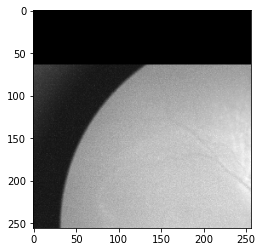

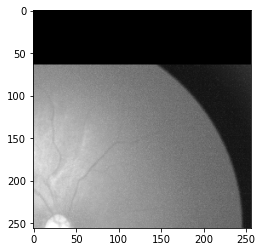

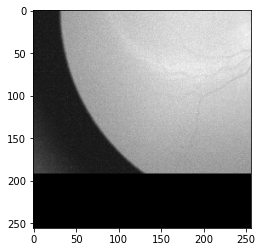

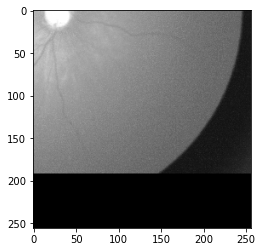

In [46]:
for i in range(0,2):
    for j in range(0,2):
        plt.figure()
        plt.imshow(cutImage[i,j,:,:,0],cmap='gray')

In [47]:
# // -- STEP 2 : Histogram Calculations -- //
hsbBrightnessMaxIntValue = 255
histogramsPerBlock = np.zeros((numblockCol,numblockRow,hsbBrightnessMaxIntValue+1),dtype=np.uint64)
minPerBlock = np.zeros((numblockCol,numblockRow),dtype=np.uint8)
maxPerBlock = np.zeros((numblockCol,numblockRow),dtype=np.uint8)
avgPerBlock = np.zeros((numblockCol,numblockRow),dtype=np.uint64)
for  blockC in range(0,numblockCol):
    for blockR in range(0,numblockRow):
        minPerBlock[blockC,blockR] = 1000
        maxPerBlock[blockC,blockR] = -1000
# // get max value and array for holding the histogram globally for 0.75 cdf
Lmax = -1000
globalHistogram = np.zeros((hsbBrightnessMaxIntValue+1,))

# // set the histogram for each block
for  blockC in range(0,numblockCol):
    for blockR in range(0,numblockRow):
        count=0
        for pixelC in range(0,pixelperblockCol):
            for pixelR in range(0,pixelperblockRow):
                count+=1
                brightness = cutImage[blockC,blockR,pixelC,pixelR,0]
#                 increment the brightness value index of the histogram for the block
                histogramsPerBlock[blockC,blockR,brightness] += 1

#                 update min, max and avg count values per block
                
                if (brightness < minPerBlock[blockC,blockR]):
                    minPerBlock[blockC,blockR]  = brightness 
                if (brightness > maxPerBlock[blockC,blockR]):
                    maxPerBlock[blockC,blockR]  = brightness 
#                 print(avgPerBlock[blockC,blockR])
                avgPerBlock[blockC,blockR] += brightness
#                 print(avgPerBlock[blockC,blockR])
                
#                 update global max
                if brightness > Lmax:
                    Lmax = brightness 
#                 update global histogram
                globalHistogram[brightness] += 1
#         print(avgPerBlock)
        avgPerBlock[blockC,blockR] /= pixelperBlock
#         print(avgPerBlock)
#         break
#     break

In [59]:
import sys

In [60]:
# // gets Lalpha such that cdf(Lalpha) = 0.75
cdfTarget = int(pixelperBlock*numblockCol*numblockRow*0.75)
LalphaDiff = sys.maxsize
Lalpha = 0
for i in range(0,len(globalHistogram)):
    if i>0:
        globalHistogram[i] += globalHistogram[i-1]
    diff = np.abs(globalHistogram[i]-cdfTarget)
    if diff < LalphaDiff:
        LalphaDiff = diff
        Lalpha = i

In [61]:
# # standard deviation for each block 1st
# stdPerBlock = np.zeros((numblockCol,numblockRow),dtype = float)
# # // calculate the standard deviation for each block
# for  blockC in range(0,numblockCol):
#     for blockR in range(0,numblockRow):
# #         // get the average for this block
#         avg = avgPerBlock[blockC,blockR]
    
# #         update stdev
#         for pixelC in range(0,pixelperblockCol):
#             for pixelR in range(0,pixelperblockRow):
#                 stdPerBlock[blockC,blockR] += np.power(cutImage[blockC,blockR,pixelC,pixelR]-avg,2)
# #         // divide by number of pixels in block
#         stdPerBlock[blockC,blockR] /= pixelperBlock
# #         take sqrt
#         stdPerBlock[blockC,blockR] = np.sqrt(stdPerBlock[blockC,blockR])
    
# standard deviation for each block 2nd
stdPerBlock = np.zeros((numblockCol,numblockRow),dtype = float)
# // calculate the standard deviation for each block
for  blockC in range(0,numblockCol):
    for blockR in range(0,numblockRow):
        stdPerBlock[blockC,blockR] = np.std(cutImage[blockC,blockR])

In [62]:
print(maxPerBlock)
print(minPerBlock)
print(avgPerBlock)
print(stdPerBlock)

[[227 255]
 [213 255]]
[[0 0]
 [0 0]]
[[97 96]
 [95 89]]
[[77.13315566 71.55577012]
 [75.13273754 65.66080867]]


In [63]:
# // -- STEP 3 : Histogram Clipping Redistribution -- //
'''Clips the histogram for each block w/ the following clipping threshold β, where:
β = (M/N)*(1+P*(lmax/R)+(α/100)*(σ/(Avg+c)))
M = # pixels in each block
N = dynamic range of the block
lmax = max pixel value in each block
R = hsbBrightnessMaxIntValue
c = 0.0001
Avg = average pixel value
P, α = passed parameters
'''
M = pixelperblockCol*pixelperblockRow

# redistribute the histogram
for  blockC in range(0,numblockCol):
    for blockR in range(0,numblockRow):
        # calculate the clipping point
        lmax = maxPerBlock[blockC,blockR]
        N = lmax-minPerBlock[blockC,blockR]
        avg = avgPerBlock[blockC,blockR]
        std = stdPerBlock[blockC,blockR]
#         print(M,std,avg,lmax,N)
        B = int((M/N)*(1.0+P*(lmax/hsbBrightnessMaxIntValue)+(alpha/100.0)*(std/(avg+0.0001))))
        print(B,std,avg)
        # store the total clipped for redistribution
        totalClipped = 0
        # Clip the histogram
        for brightness in range(0,hsbBrightnessMaxIntValue+1):
            brightnessCount = histogramsPerBlock[blockC,blockR,brightness]
            if brightnessCount>B:
#                 print('clipping')
                # add amount clipped
                totalClipped += brightnessCount-B
                # clip
                histogramsPerBlock[blockC,blockR,brightness] = B
                
        # redistribute amount of each brightness
        redistributionPerBrightness = totalClipped/(hsbBrightnessMaxIntValue+1)
        # redistribute
        for brightness in range(0,hsbBrightnessMaxIntValue+1):
            histogramsPerBlock[blockC,blockR,brightness] += redistributionPerBrightness

775 77.13315566236263 97
705 71.55577011878727 96
808 75.13273753790871 95
703 65.66080866912267 89


In [65]:
# // STEP 4 - Histogram Equalization Function Mapping -- //
# // Calculate mapped value for each brightness value per block w/ histogram equalization
for  blockC in range(0,numblockCol):
    for blockR in range(0,numblockRow):
#         // store the histogram for pdf calculations
        storedHisto = np.zeros((hsbBrightnessMaxIntValue+1,))
        storedHisto[0] = histogramsPerBlock[blockC,blockR,0]
        # min and max pdf
        pdfMin = storedHisto[0]
        pdfMax = storedHisto[0]
        
        # calculate running histogram
        for brightness in range(1,hsbBrightnessMaxIntValue+1):
            # update for pdf
            storedHisto[brightness] = histogramsPerBlock[blockC,blockR,brightness]
            # update for min and max pdf
            if storedHisto[brightness] < pdfMin:
                pdfMin = storedHisto[brightness]
            if storedHisto[brightness] > pdfMax:
                pdfMax = storedHisto[brightness]
            # update for cdf
            histogramsPerBlock[blockC,blockR,brightness] += histogramsPerBlock[blockC,blockR,brightness-1]
        
        # pdf weighted calculations
        cumulativeHistoWeighted = np.zeros((hsbBrightnessMaxIntValue+1,))
        for brightness in range(0,hsbBrightnessMaxIntValue+1):
            cumulativeHistoWeighted[brightness] = pdfMax * ((storedHisto[brightness]-pdfMin)/(pdfMax-pdfMin))
            if brightness > 0:
                cumulativeHistoWeighted[brightness] += cumulativeHistoWeighted[brightness-1]
                
        # get sum of cumulativeHistoWeighteabsd
        pdfSum = cumulativeHistoWeighted[hsbBrightnessMaxIntValue]
        
        # the maximum value for this block
        maxValueInBlock = maxPerBlock[blockC,blockR]
        
        # r: dynamic range of the block
        r = maxPerBlock[blockC,blockR]-minPerBlock[blockC,blockR]
        
        # the Histogram equalization factor
        cdfFactor = histogramsPerBlock[blockC,blockR,hsbBrightnessMaxIntValue]
        
        # calculate mapping function
        for brightness in range(0,hsbBrightnessMaxIntValue+1):
            # get cdf of l
            cdf = histogramsPerBlock[blockC,blockR,brightness] / cdfFactor
            
            # weighted enhancement for gamma 1
            gamma1 = 1.0-(np.log(np.e+cdf)/8)
            Wen = np.power(Lmax/Lalpha,gamma1)
            
            #T1
            T1 = int(maxValueInBlock*Wen*cdf)
            if T1 > hsbBrightnessMaxIntValue:
                T1 = hsbBrightnessMaxIntValue
                
            # Gamma calculation
            gamma2 = (1.0 + (cumulativeHistoWeighted[brightness]/pdfSum))/2.0
            Gamma = int(Lmax*np.power(brightness/Lmax,gamma2))
            
            # Set L
            if r>((D*hsbBrightnessMaxIntValue)/100.0):
                histogramsPerBlock[blockC,blockR,brightness] = np.max([T1,Gamma])
            else:
                histogramsPerBlock[blockC,blockR,brightness] = Gamma
#             break
#         break
#     break

In [95]:
# STEP 5 - Bilinear Interpolation
hsbBrightnessNewValues = np.zeros((hsv.shape[0],hsv.shape[1]),dtype=np.uint8)
halfPixelsPerBlockCol = pixelperblockCol / 2
halfPixelsPerBlockRow = pixelperblockRow / 2

# set the new image
for c in range(0,hsv.shape[0]):
    for r in range(0,hsv.shape[1]):
        p = hsbBrightnessValues[c][r]
        
        blockC = int(c/pixelperblockCol)
        blockR = int(r/pixelperblockRow)
        
        centerBlockC = blockC * pixelperblockCol+halfPixelsPerBlockCol
        centerBlockR = blockR * pixelperblockRow+halfPixelsPerBlockRow
        
        if c<centerBlockC:
            bc1 = blockC-1
            if bc1<0:
                bc1 = 0
            bc2 = blockC
        else:
            bc1 = blockC
            bc2 = blockC+1
            if bc2>=numblockCol:
                bc2 = blockC
                
        if r<centerBlockR:
            br1 = blockR-1
            if br1<0 :
                br1 = 0
            br2 =blockR
        else:
            br1 = blockR
            br2 = blockR+1
            if br2>=numblockRow:
                br2 = blockR
        c1 = bc1*pixelperblockCol+halfPixelsPerBlockCol
        c2 = bc2*pixelperblockCol+halfPixelsPerBlockCol
        r1 = br1*pixelperblockRow+halfPixelsPerBlockRow
        r2 = br2*pixelperblockRow+halfPixelsPerBlockRow
        
        m = 0 if (c2-c1 == 0) else ((c2-c)/(c2-c1))
        n = 0 if (r2-r1 == 0) else ((r2-r)/(r2-r1))
        
        Ta = histogramsPerBlock[bc1][br1][p]
        Tb = histogramsPerBlock[bc1][br2][p]
        Tc = histogramsPerBlock[bc2][br1][p]
        Td = histogramsPerBlock[bc2][br2][p]
        
        hsbBrightnessNewValues[c][r] = int(m*(n * Ta + (1 - n) * Tb)+(1-m)*(n * Tc + (1 - n) * Td))       

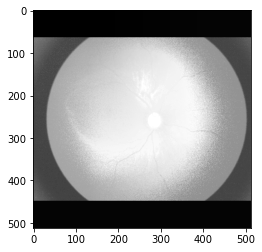

In [96]:
plt.imshow(hsbBrightnessNewValues,cmap='gray')

In [104]:
# plt.hist(hsbBrightnessNewValues.flatten(),256);

In [98]:
hsv_merge = cv2.merge([h,s,hsbBrightnessNewValues])
bgr = cv2.cvtColor(hsv_merge,cv2.COLOR_HSV2BGR)
cv2.imshow('bgr',bgr)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [14]:
import glob
import h5py

In [15]:
config_hrf[-1]

'G:\\My Drive\\CMKL\\datasets\\image_patches\\grayscale_HRF\\train\\59\\desktop.ini'

In [55]:
main_dir = r'G:\My Drive\CMKL\datasets\image_patches'
config_hrf = glob.glob(os.path.join(main_dir,'grayscale_HRF','*','*','*'))
config_hrf = [i for i in config_hrf if '.ini' not in i]
# main_dir = r'G:\My Drive\CMKL\datasets\image_patches'
config_iostar = glob.glob(os.path.join(main_dir,'patch_grayscale_IOSTAR','*','*','*'))
config_iostar = [i for i in config_iostar if '.ini' not in i]

In [56]:
config_hrf[-1],config_iostar[-1]

('G:\\My Drive\\CMKL\\datasets\\image_patches\\grayscale_HRF\\train\\59\\06_gx_329y_504_shape256.h5',
 'G:\\My Drive\\CMKL\\datasets\\image_patches\\patch_grayscale_IOSTAR\\train\\32\\STAR 30x_521y_495_shape256.h5')

In [60]:
config_all = {'train':[],'validate':[]}
for tmp in [config_iostar,config_hrf]:
    for i in tmp:
        print(i)
        i = i.replace(r'\\','/')
        print(i)
        group = i.split('/')[-3]
        id_name = i.split('/')[-4:]
        print(id_name)
        break
    break

G:\My Drive\CMKL\datasets\image_patches\patch_grayscale_IOSTAR\validation\1\STAR 48x_329y_336_shape256.h5
G:\My Drive\CMKL\datasets\image_patches\patch_grayscale_IOSTAR\validation\1\STAR 48x_329y_336_shape256.h5


IndexError: list index out of range

In [59]:
i

'G:\\My Drive\\CMKL\\datasets\\image_patches\\patch_grayscale_IOSTAR\\validation\\1\\STAR 48x_329y_336_shape256.h5'

In [31]:
fl = config_hrf[0]
with h5py.File(fl, 'r') as f:
    xi = np.array(f.get("x"))
    yi = np.array(f.get("y"))
    yi = np.moveaxis(yi[:,:,:,0],0,-1)

In [39]:
yi_tmp = np.zeros((yi.shape[0],yi.shape[1]))

In [62]:
xi.shape,yi_tmp.shape

((256, 256, 3), (256, 256))

In [63]:
np.unique(yi_tmp)

array([1., 2., 3.])

In [44]:
for i in range(0,yi.shape[0]):
    for j in range(yi.shape[1]):
        yi_tmp[i,j]=np.argmax(yi[i,j])

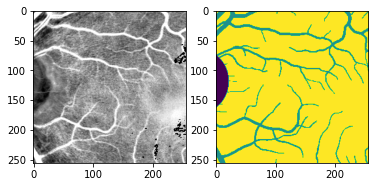

In [46]:
_,ax = plt.subplots(1,2)
ax[0].imshow(xi)
ax[1].imshow(yi_tmp)

In [65]:
xi[0,0]

array([36, 36, 36], dtype=uint8)